### Address "weirdness" in CPN data
* Delta noise corr. opposite direction
* Delta dprime opposite direction
* Delta noise in the dDR space foes oppisite direction
(These all seem to happen more for this data than for the NAT data. Why?)

In [122]:
import sys
sys.path.append('/home/charlie/Desktop/lbhb/code/projects/nat_pup_ms/')
from path_settings import DPRIME_DIR, PY_FIGURES_DIR2, CACHE_PATH
from global_settings import ALL_SITES, LOWR_SITES, HIGHR_SITES, CPN_SITES
import charlieTools.nat_sounds_ms.decoding as decoding
import load_results as ld
import nems.db as nd
import charlieTools.nat_sounds_ms.preprocessing as nat_preproc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### NOISE CORRELATION RESULTS

In [7]:
rsc = ld.load_noise_correlation('rsc_ev_perstim')

no results found for site: AMT021b, model: rsc_ev_perstim
no results found for site: ARM005e, model: rsc_ev_perstim
no results found for site: CRD005b, model: rsc_ev_perstim
no results found for site: CRD019b, model: rsc_ev_perstim


In [8]:
# keep only CPN sites
rsc = rsc[rsc.site.isin(CPN_SITES)]

# remove nans
na = (~rsc.bp.isna()) & (~rsc.sp.isna())
rsc = rsc[na]

# add columns for deltas
rsc['delta_gm'] = rsc.gm_bp - rsc.gm_sp
rsc['delta_rsc'] = rsc.sp - rsc.bp

# exclude the low FR pairs
rscg = rsc[(rsc.gm_bp>1) & (rsc.gm_sp>1)]

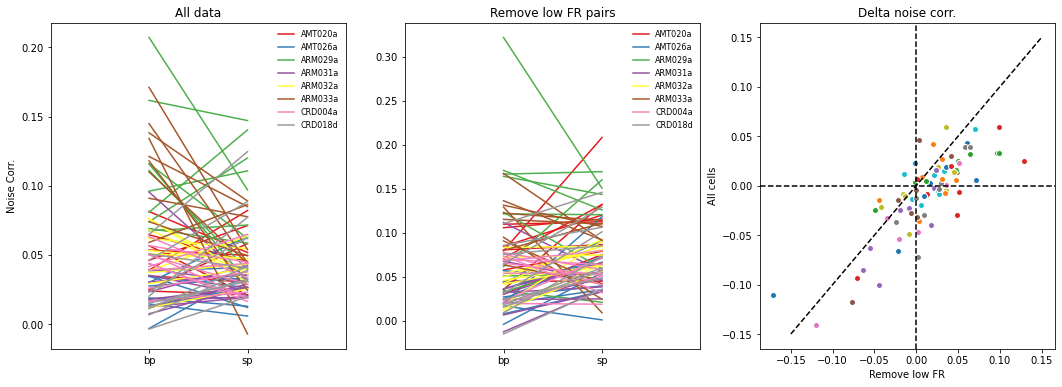

In [34]:
# plot noise correlation before / after removing low FR pairs for all sites
gr = rsc.groupby(by=['site', 'stim']).mean()
grg = rscg.groupby(by=['site', 'stim']).mean()

cmap = plt.cm.get_cmap('Set1', len(rsc.site.unique()))
f, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, s in enumerate(rsc.site.unique()):
    for j, stim in enumerate(gr[gr.index.get_level_values(0)==s].index.get_level_values(1).unique()):
        if j==0:
            lab=s
        else:
            lab=None
        m = (gr.index.get_level_values(0)==s) & (gr.index.get_level_values(1)==stim)
        ax[0].plot([0, 1], [gr[m].bp, gr[m].sp], color=cmap(i), label=lab)

        m = (grg.index.get_level_values(0)==s) & (grg.index.get_level_values(1)==stim)
        ax[1].plot([0, 1], [grg[m].bp, grg[m].sp], color=cmap(i), label=lab)

        ax[2].scatter(grg[m].delta_rsc, gr[m].delta_rsc, label=lab, edgecolor='white')

ax[0].legend(fontsize=8, frameon=False)
ax[1].legend(fontsize=8, frameon=False)
ax[0].set_xticks([0, 1]); ax[0].set_xticklabels(['bp', 'sp'])
ax[1].set_xticks([0, 1]); ax[1].set_xticklabels(['bp', 'sp'])
ax[0].set_ylabel("Noise Corr.")
ax[0].set_title("All data")
ax[1].set_title("Remove low FR pairs")
ax[0].set_xlim((-1, 2))
ax[1].set_xlim((-1, 2))
ax[2].axhline(0, linestyle='--', color='k')
ax[2].axvline(0, linestyle='--', color='k')
ax[2].set_title("Delta noise corr.")
ax[2].set_xlabel("Remove low FR")
ax[2].set_ylabel("All cells")
ax[2].plot([-0.15, 0.15], [-0.15, 0.15], 'k--')

### noise correlations vs. delta noise in dDR space

In [41]:
# load decoding results and append the apprpriate noise correlations to the dataframe.

# Use only the "good" noise correlations
rsc = rscg.copy()


path = DPRIME_DIR
loader = decoding.DecodingResults()
recache = False
df_all = []
sites = CPN_SITES
batches = [331]*len(CPN_SITES)
modelname = 'dprime_pr_rm2_jk10_zscore_nclvz_fixtdr2'
modelname = 'dprime_jk10_zscore_nclvz_fixtdr2'
ndim = 2

sim = []
for i, (batch, site) in enumerate(zip(batches, sites)):
    if (site in LOWR_SITES) & (batch != 331):
        mn = modelname.replace('_jk10', '_jk1_eev')
    else:
        mn = modelname
    if site in ['BOL005c', 'BOL006b']:
        batch = 294
    try:
        fn = os.path.join(path, str(batch), site, mn+'_TDR.pickle')
        results = loader.load_results(fn, cache_path=None, recache=recache)
        _df = results.numeric_results
    except:
        raise ValueError(f"WARNING!! NOT LOADING SITE {site}")

    stim = results.evoked_stimulus_pairs
    _df = _df.loc[pd.IndexSlice[stim, ndim], :]
    _df['site'] = site
    _df['sp_noise_mag'] = results.array_results['sp_evals'].loc[pd.IndexSlice[stim, ndim], 'mean'].apply(lambda x: x.sum())
    _df['bp_noise_mag'] = results.array_results['bp_evals'].loc[pd.IndexSlice[stim, ndim], 'mean'].apply(lambda x: x.sum())
    _df['noise_alignment'] = results.slice_array_results('cos_dU_evec_test', stim, ndim, idx=(0,0))[0]
    _df['delta_dprime'] = (_df['bp_dp'] - _df['sp_dp']) / (_df['bp_dp'] + _df['sp_dp'])

    # add epoch names back to dataframe
    _df['epoch1'] = [results.mapping[k][0] for k in _df.index.get_level_values(0)]
    _df['epoch2'] = [results.mapping[k][1] for k in _df.index.get_level_values(0)]

    # add mean big/small pupil noise correlation for each epoch
    _df['rsc_epoch1_big'] = [rsc[(rsc.site==site) & (rsc.stim==e1)].bp.mean() for e1 in _df['epoch1']]
    _df['rsc_epoch1_small'] = [rsc[(rsc.site==site) & (rsc.stim==e1)].sp.mean() for e1 in _df['epoch1']]
    _df['rsc_epoch2_big'] = [rsc[(rsc.site==site) & (rsc.stim==e2)].bp.mean() for e2 in _df['epoch2']]
    _df['rsc_epoch2_small'] = [rsc[(rsc.site==site) & (rsc.stim==e2)].sp.mean() for e2 in _df['epoch2']]
    _df['rsc_epoch1_delta'] = _df['rsc_epoch1_small'] - _df['rsc_epoch1_big']
    _df['rsc_epoch2_delta'] = _df['rsc_epoch2_small'] - _df['rsc_epoch2_big']
    _df['rsc_mean_delta'] = (_df['rsc_epoch1_delta'] + _df['rsc_epoch2_delta']) / 2
    df_all.append(_df)

df = pd.concat(df_all)
df['delta_noise'] = (df['sp_noise_mag'] - df['bp_noise_mag']) / (df['sp_noise_mag'] + df['bp_noise_mag'])

[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM029a/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM031a/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM032a/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM033a/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/CRD004a/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root 

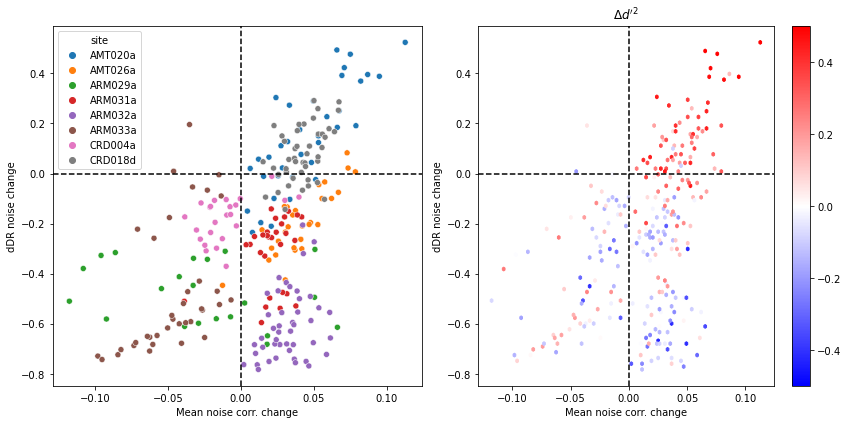

In [46]:
# dDR noise change vs. mean noise correlation change
# **only for stim pairs where both stim's noise corr. change in same direction** to avoid ambiguity
f, ax = plt.subplots(1, 2, figsize=(12, 6))
mask = ((df['rsc_epoch1_delta']<0) & (df['rsc_epoch2_delta']<0)) | ((df['rsc_epoch1_delta']>0) & (df['rsc_epoch2_delta']>0))
sns.scatterplot(x='rsc_mean_delta', y='delta_noise', data=df[mask], hue='site', ax=ax[0])

ax[0].axhline(0, linestyle='--', color='k')
ax[0].axvline(0, linestyle='--', color='k')

ax[0].set_xlabel('Mean noise corr. change')
ax[0].set_ylabel('dDR noise change')

df[mask].plot.hexbin(
    x='rsc_mean_delta',
    y='delta_noise',
    C='delta_dprime',
    cmap='bwr',
    vmin=-0.5,
    vmax=0.5,
    ax=ax[1]
)
ax[1].axhline(0, linestyle='--', color='k')
ax[1].axvline(0, linestyle='--', color='k')
ax[1].set_xlabel('Mean noise corr. change')
ax[1].set_ylabel('dDR noise change')
ax[1].set_title(r"$\Delta d'^2$")
f.tight_layout()

### Investigate example pairs in the lower right quadrant.
* Why doesn't dDR refelct noise correlation changes?

In [48]:
site = 'ARM032a'
site_mask = df.site==site

example_pairs = df[(df.delta_noise<0) & (df.rsc_mean_delta>0) & site_mask].sortby(by='rsc_mean_delta', ascending=False)

In [123]:
# load data and extract a sample pair of stimuli
e1, e2 = example_pairs['epoch1'].iloc[0], example_pairs['epoch2'].iloc[0]
idx = example_pairs.index.get_level_values(0)[0]
i1, i2 = int(idx.split('_')[0]), int(idx.split('_')[1])

X, sp_bins, X_pup, pup_mask, epochs = decoding.load_site(site=site, batch=331, 
                                       return_epoch_list=True)
ncells = X.shape[0]
nreps = X.shape[1]
nstim = X.shape[2]
nbins = X.shape[3]
sp_bins = sp_bins.reshape(1, sp_bins.shape[1], nstim * nbins)
nstim = nstim * nbins
nreps = X.shape[1]

# =============================== reshape data ===================================
# reshape mask to match data
pup_mask = pup_mask.reshape(1, nreps, nstim)
# reshape X 
X = X.reshape(ncells, nreps, nstim)
# reshape X_pup
X_pup = X_pup.reshape(1, nreps, nstim)

X, _ = nat_preproc.scale_est_val([X], [X])
X = X[0]

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/331/ARM032a_75218132cc4bcb10d2dac30e70e4f19b6b0e92f4.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[root INFO] Extracting cellids: ['ARM032a-12-1', 'ARM032a-12-2', 'ARM032a-13-2', 'ARM032a-14-1', 'ARM032a-15-3', 'ARM032a-15-4', 'ARM032a-18-3', 'ARM032a-18-4', 'ARM032a-19-2', 'ARM032a-19-3', 'ARM032a-20-2', 'ARM032a-20-3', 'ARM032a-21-4', 'ARM032a-21-5', 'ARM032a-22-5', 'ARM032a-22-6', 'ARM032a-22-7', 'ARM032a-22-8', 'ARM032a-22-9', 'ARM032a-23-1', 'ARM032a-24-5', 'ARM032a-24-6', 'ARM032a-24-7', 'ARM032a-25-3', 'ARM032a-25-4', 'ARM032a-26-3', 'ARM032a-26-4', 'ARM032a-27-4', 'ARM032a-27-5', 'ARM032a-28-4', 'ARM032a-28-5', 'ARM032a-28-6', 'ARM032a-30-2', 'ARM032a-31-2', 'ARM032a-34-2', 'ARM032a-36-3', 'ARM032a-36-4', 'ARM032a-37-1', 'ARM032a-39-2', 'ARM032a-40-1', 'ARM032a-45-1', 'ARM032a-46-2', 'ARM032a-51-1']


In [124]:
# get dDR plane for this site
fn = os.path.join(path, str(batch), site, mn+'_TDR.pickle')
results = loader.load_results(fn, cache_path=None, recache=recache)
dU = results.array_results['dU_all'].loc[pd.IndexSlice[idx, 2]]['mean']
dU /= np.linalg.norm(dU)
evec1 = results.array_results['evecs_all'].loc[pd.IndexSlice[idx, 2]]['mean'][:, 0]
evec1 /= np.linalg.norm(evec1)

# figure out the axis that spans the plane with dU
noise_on_dec = (np.dot(evec1, dU.T)) * dU
orth_ax = evec1 - noise_on_dec
orth_ax /= np.linalg.norm(orth_ax)

weights = np.concatenate((dU, orth_ax), axis=0)

[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM032a/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle


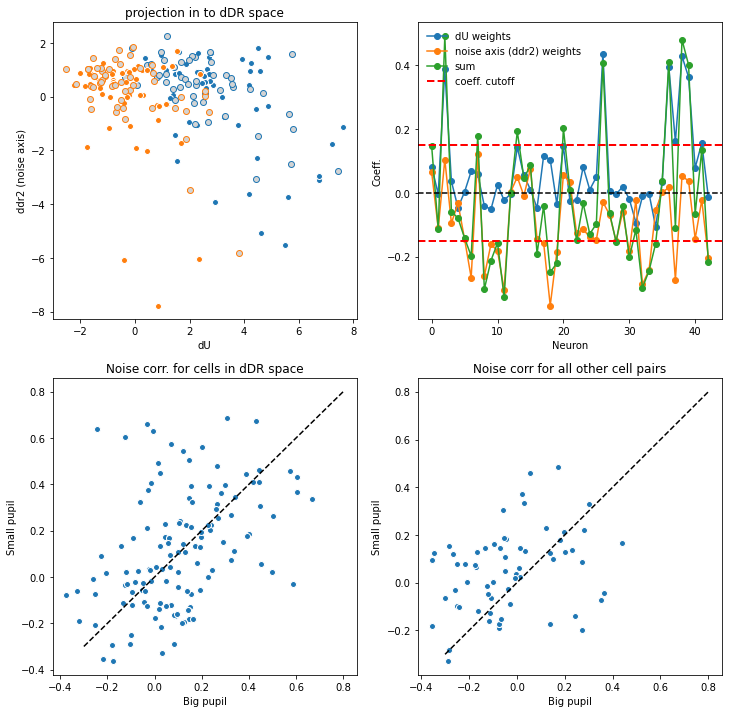

In [125]:
xddr = X[:, :, [i1, i2]].T.dot(weights.T)
bp = X_pup[:, :, [i1, i2]] > np.median(X_pup[:, :, [i1, i2]], axis=(0, 1), keepdims=True)
sp = ~bp
cutoff = 0.15 # cells with dDR coef > cutoff are "included"

# plot data in dDR space and show distribution of dDR weights (dominated by single neuron?)
f, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].scatter(xddr[0, bp[0, :, 0], 0], xddr[0, bp[0, :, 0], 1], color='tab:blue', edgecolor='white')
ax[0, 0].scatter(xddr[0, sp[0, :, 0], 0], xddr[0, sp[0, :, 0], 1], color='lightgrey', edgecolor='tab:blue')
ax[0, 0].scatter(xddr[1, bp[0, :, 1], 0], xddr[1, bp[0, :, 1], 1], color='tab:orange', edgecolor='white')
ax[0, 0].scatter(xddr[1, sp[0, :, 1], 0], xddr[1, sp[0, :, 1], 1], color='lightgrey', edgecolor='tab:orange')
ax[0, 0].set_title("projection in to dDR space")
ax[0, 0].set_xlabel('dU')
ax[0, 0].set_ylabel('ddr2 (noise axis)')

ax[0, 1].plot(weights[0, :], 'o-', label='dU weights')
ax[0, 1].plot(weights[1, :], 'o-', label='noise axis (ddr2) weights')
ax[0, 1].plot(np.sum(weights, axis=0), 'o-', label='sum')
ax[0, 1].axhline(cutoff, linestyle='--', color='red', lw=2, label='coeff. cutoff')
ax[0, 1].axhline(-cutoff, linestyle='--', color='red', lw=2)
ax[0, 1].axhline(0, linestyle='--', color='k')
ax[0, 1].legend(frameon=False)
ax[0, 1].set_xlabel('Neuron')
ax[0, 1].set_ylabel('Coeff.')

# plot noise correlations for these two stimuli for the neurons with big coef, and with small coef (not present in dDR space)
gidx = np.argwhere(np.abs(np.sum(weights, axis=0))>cutoff).squeeze()
cids_all = np.array([c for c in nd.get_batch_cells(batch).cellid if site in c])
cids_ddr = cids_all[gidx]
cids_rem = np.array([c for c in cids_all if c not in cids_ddr])

_rsc = rsc[(rsc.site==site) & ((rsc.stim==e1) | (rsc.stim==e2))]
ddr_nc = [idx for idx in _rsc.index if (idx.split('_')[0] in cids_ddr) & (idx.split('_')[1] in cids_ddr)]
ddr_nc = _rsc.loc[ddr_nc]
rem_nc = [idx for idx in _rsc.index if (idx.split('_')[0] in cids_rem) & (idx.split('_')[1] in cids_rem)]
rem_nc = _rsc.loc[rem_nc]

ax[1, 0].set_title("Noise corr. for cells in dDR space")
ax[1, 0].scatter(ddr_nc.bp, ddr_nc.sp, edgecolor='white')
ax[1, 0].set_xlabel('Big pupil')
ax[1, 0].set_ylabel('Small pupil')
ax[1, 0].plot([-0.3, 0.8], [-0.3, 0.8], 'k--')

ax[1, 1].set_title("Noise corr for all other cell pairs")
ax[1, 1].scatter(rem_nc.bp, rem_nc.sp, edgecolor='white')
ax[1, 1].set_xlabel('Big pupil')
ax[1, 1].set_ylabel('Small pupil')
ax[1, 1].plot([-0.3, 0.8], [-0.3, 0.8], 'k--')